In [1]:
#Importing required modules
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from csv import writer

In [2]:
def EV_Instance(EV, H):
    EV_data = []
    for k in range(EV):
        Arrival = random.randint(0,H-1)
        Deadline = random.randint(Arrival,H-1)
#         Arrival = 0
#         Deadline = H-1
        Energy_demand = random.randint(20, 200)
        EV_data.append([Arrival, Deadline, Energy_demand])
    return EV_data

In [3]:
# Inputs

# Instance = [[0, 2, 66], [1, 3, 90], [1, 3, 60], [2, 4, 30], [0, 4, 50]]
# Instance = [[5, 8, 36], [0, 9, 53], [9, 9, 33], [4, 5, 61], [2, 3, 132], [7, 7, 54], [0, 0, 37], [7, 7, 198],
#             [5, 7, 34], [2, 6, 181], [7, 8, 48], [5, 6, 112], [5, 9, 20], [3, 4, 174], 
#             [8, 8, 138], [5, 8, 36], [8, 8, 183], [3, 5, 125], [9, 9, 112], [8, 8, 134], [7, 8, 153], 
#             [9, 9, 109], [4, 7, 157], [8, 9, 39], [0, 8, 70], [0, 4, 75], [9, 9, 37], [3, 9, 84], 
#             [7, 8, 122], [8, 8, 124], [2, 2, 109], [9, 9, 162], [3, 4, 131], [8, 8, 83], [0, 2, 96],
#             [2, 7, 157], [5, 8, 78], [4, 4, 96], [2, 3, 28], [1, 6, 45], [9, 9, 142], [1, 7, 175], 
#             [3, 6, 100], [7, 9, 158], [9, 9, 40], [7, 8, 45], [2, 4, 32], [7, 8, 95], [9, 9, 141], [1, 8, 132]]

N = 500 #Population size

R_fast = 60
R_slow = 20
W_penalty = -1
D_penalty = -2

ports = 10

F = R_fast
S = R_slow
W = W_penalty
D = D_penalty

sp_fast = 1.31 # selling price for fast charging
sp_slow = 1.11 # selling price for slow charging

# variables 'alpha', 'beta' for calculating customer satisfaction:
alpha = 1
beta = 1

HEIGHT = len(Instance) # No. of EVs
WIDTH = 10 #No. of time slots

# Instance = EV_Instance(HEIGHT, WIDTH)

In [4]:
# Pick an option randomly
def pickReward(pick):
    return random.choice(pick)

In [5]:
def checkPortsConstraint(X):
    X = np.transpose(X)
    for t,T in enumerate(X):
        occurances = sum(T == F) + sum(T == S)
        if (occurances > ports):
            return t # The time at which there is a constraint failure
    return -1 # Here -1 means ports constraint is satisfied

In [6]:
def pricing_Model(E):
    gridPrice = (E*E)/1000
    return gridPrice

In [7]:
def expectedSlots(c1, c2):
    
    a = np.array([[F, S], [1, 1]])
    b = np.array([c1, c2])
    x = np.linalg.solve(a, b)
    return x

In [8]:
def generateSolutions():
#     Define options to pick from
    pick = [F, S, W_penalty, D_penalty]
    X = []
    
    for k in range(HEIGHT):
        each_k = []
        total = 0
        for t in range(WIDTH):
            picked = pickReward(pick)
            
            if t < Instance[k][0]: # If 't' is before Arrival time, choose 0
                picked = 0
                each_k.append(picked)
            if t == Instance[k][0]: # If 't' is at the time of arrival, choose something
                each_k.append(picked)
            if t > Instance[k][1]: # If 't' is after the deadline, choose 0
                picked = 0
                each_k.append(picked)
            elif(t > Instance[k][0] and t <= Instance[k][1]): # If 't' is within the arrival and deadline
                
#         Add constraints
#         1. Find the total energy fulfilled, assign 0 if demand fulfilled
                if (each_k[t-1] == F or each_k[t-1] == S):
                    total = total + each_k[t-1]
            
                if (total >= Instance[k][2]):
                    picked = 0
                    each_k.append(picked)
                    
#         2. If 'D' is chosen, the rest of the time slots should be 0
                elif(each_k[t-1] == D_penalty or each_k[t-1] == 0):
                    picked = 0
                    each_k.append(picked)
                else:
                    each_k.append(picked)
                    
#         3. Not exceeding the total number of ports 
        X.append(each_k)
        while(checkPortsConstraint(X) != -1): # This means the ports are occupied
            idx = checkPortsConstraint(X)
            X[k][idx] = pickReward([W_penalty, D_penalty])
            if X[k][idx] == D_penalty:
                for i in range(idx+1, Instance[k][1]+1):
                    X[k][i] = 0
#     X = np.array(X)
               
    return X

In [9]:
def calculateRevenue(Allocation_table):
    Allocation_table = np.array(Allocation_table)
#     print("Alloc:",Allocation_table)
    
#     Transpose of Allocation table
    Allocation_table = np.transpose(Allocation_table)
#     print("After transpose",Allocation_table, "\n")

    gridPriceTable = []
    
    Total_revenue = 0
    
    onlyProfit = 0 # Used to find the comparison graph for only 'Charging cost' or 'Revenue' in the results
#     section
    
    for t in Allocation_table: #'t' time slot
#         print("\nt:",t)
        
        [count_F] = np.where(t == F) #Fast charging
#         print("count of F:",count_F)
        count_F = len(count_F)
        E = count_F * F 
#         print("Energy:",E)
        [count_S] = np.where(t == S) #Slow charging
#         print("count of S:",count_S)
        count_S = len(count_S)
        E = E + count_S * S
#         print("Energy:",E)
        
        gridPrice = pricing_Model(E)
        
        slow_charger_price = sp_slow * gridPrice
        fast_charger_price = sp_fast * gridPrice
        profit = (fast_charger_price - gridPrice)*count_F + (slow_charger_price - gridPrice)*count_S
        
        onlyProfit = onlyProfit + profit
        
        [count] = np.where(t == W) #Waiting
        count = len(count)
        total_W_penalty = count * W_penalty
#         print("Total W penalty:",total_W_penalty)
        profit = profit + total_W_penalty
        
        [count] = np.where(t == D) #Denied
        count = len(count)
        total_D_penalty = count * D_penalty
#         print("Total D penalty:",total_D_penalty)
        profit = profit + total_D_penalty
        
        Total_revenue = Total_revenue + profit
        
        gridPriceTable.append(gridPrice)
    gridPriceTable = np.array(gridPriceTable)
    
#     print("Revenue:",Total_revenue)
    
    return gridPriceTable, Total_revenue
#     return gridPriceTable, onlyProfit # For the comparison graph in the result section


In [10]:
def calculateCS(Allocation_table, gridPriceTable):
    Allocation_table = np.array(Allocation_table)
#     gridPriceTable = np.array(gridPriceTable)
    
    total_CustomerSatisfaction = 0
    
    for cust in range(len(Allocation_table)):
        E_charged = 0
        
#         Calculate the first product
        total_allowedTime = Instance[cust][1] - Instance[cust][0] + 1
#         print(" ",total_allowedTime)
        [count] = np.where((Allocation_table[cust] == F) | (Allocation_table[cust] == S)
                          | (Allocation_table[cust] == W))
        count = len(count)
#         print(" Charged for:",count,"times")
        total_chargedTime = count
        term_1 = 1 - total_chargedTime/total_allowedTime
#         print(" First product:", term_1)
        
#         Calculate the second product
        [count] = np.where(Allocation_table[cust] == F)
        count = len(count)
#         print(" ",count)
        E_charged = E_charged + count * F
        [count] = np.where(Allocation_table[cust] == S)
        count = len(count)
#         print(" ",count)
        E_charged = E_charged + count * S
        E_demand = Instance[cust][2]
        if E_charged>E_demand:
            E_charged = E_demand
        
#         print("Total E charged:",E_charged)
        term_2 = E_charged/E_demand
#         print("second product:",term_2)

        c1 = E_demand
        c2 = total_allowedTime
        
        expectedAllocation = expectedSlots(c1, c2)
        f = expectedAllocation[0] # No. of expected fast chargers
        s = expectedAllocation[1] # No. of expected slow chargers
        t_Arrival = Instance[cust][0]
        gridPrice_atArrival = gridPriceTable[t_Arrival]
        
        expectedSellingPrice = (f * sp_fast + s * sp_slow) * gridPrice_atArrival

# #         print("expected selling price", expectedSellingPrice)
        
        actualSellingPrice = 0
        
        for t in range(WIDTH):
            if (Allocation_table[cust][t] == F):
                actualSellingPrice = actualSellingPrice + sp_fast * gridPriceTable[t]
            elif (Allocation_table[cust][t] == S):
                actualSellingPrice = actualSellingPrice + sp_slow * gridPriceTable[t]

# #         print("actual selling price", actualSellingPrice)
        Pa_by_Pe = (actualSellingPrice + 0.0000001)/(expectedSellingPrice + 0.0000001)
        
        term_3 = alpha * Pa_by_Pe + beta

        indiv_customerSatisfation = term_1 * term_2 / term_3
        
        total_CustomerSatisfaction = total_CustomerSatisfaction + indiv_customerSatisfation
    return(total_CustomerSatisfaction)

In [11]:
#Function to carry out NSGA-II's fast non dominated sort
def fast_non_dominated_sort(R, CS):
    S=[[] for i in range(len(CS))] #Set of solutions that the particular solution 'p' dominates
    front = [[]] 
    
    n=[0 for i in range(len(R))] # No. of solutions that dominate 'p'
    rank = [0 for i in range(len(R))]

    for p in range(len(R)):
        S[p]=[]
        n[p]=0
        
        for q in range(len(R)):
#             if (R[p] >= R[q] and CS[p] >= CS[q]) and ((R[p] > R[q]) or (CS[p] > CS[q])):
            if ((R[p] > R[q] and CS[p] > CS[q]) or 
                (R[p] >= R[q] and CS[p] > CS[q]) or 
                (R[p] > R[q] and CS[p] >= CS[q])):
                if q not in S[p]:
                    S[p].append(q)
#             elif (R[p] <= R[q] and CS[p] <= CS[q]) and ((R[p] < R[q]) or (CS[p] < CS[q])):
            elif ((R[q] > R[p] and CS[q] > CS[p]) or 
                  (R[q] >= R[p] and CS[q] > CS[p]) or 
                  (R[q] > R[p] and CS[q] >= CS[p])):
                n[p] = n[p] + 1
                
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

#     Increase the rank of all solutions not present in front i by 1
    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] = n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front, rank

In [12]:
def checkEnergyConstraint(X, D):
    X = np.array(X)
    
    total = sum(X == 60)*60 + sum(X == 20)*20
    if total >= D:
        return 1 # Demand already fulfilled
    return -1 # Demand still not fulfilled

In [13]:
def checkPortsConstraint_at_t(X,t):
    X = np.transpose(X)
    occurances = sum(X[t] == F) + sum(X[t] == S)
    if occurances == ports:
#         prints("ports full")
        return 1 # Ports already full
    return -1 # Ports still empty

In [14]:
class solutions:
    def __init__(self):
        self.R = 0 # Revenue
        self.S = 0 # Customer Satisfaction

In [15]:
def expand(P, old_state):
    beta = 0
#     print("\nOld P:",P)
#     print("Beta:", old_state)
    
    for k in range(HEIGHT):
#         print("k:",k)
        Energy_demand = Instance[k][2]
    
        if(checkEnergyConstraint(P[k], Energy_demand) == -1):
            Arrival = Instance[k][0]
            Deadline = Instance[k][1]
            
            for t in range(Arrival, Deadline+1):
                if(checkEnergyConstraint(P[k], Energy_demand) == -1):
                    if P[k][t] == S:
                        P[k][t] = F
                        if (sum(P[k][Arrival:t+1]) > Energy_demand) and (t < Deadline):
                            for t1 in range(t+1, Deadline+1):
                                P[k][t1] = 0
                            break
                            
                    elif (P[k][t] == W and (checkPortsConstraint_at_t(P,t) == -1)):
                        P[k][t] = S
                        if (sum(P[k][Arrival:t+1]) > Energy_demand) and (t < Deadline):
                            for t1 in range(t+1, Deadline+1):
                                P[k][t1] = 0
                            break
                    elif (P[k][t] == D and (checkPortsConstraint_at_t(P,t) == -1)):
                        prob = random.random()
                        if prob > 0.5:
                            P[k][t] = W
                            if t+1 <= Deadline:
                                P[k][t+1] = D
                                break
                        else:
                            P[k][t] = S
                            if (sum(P[k][Arrival:t+1]) > Energy_demand) and (t < Deadline):
                                for t1 in range(t+1, Deadline+1):
                                    P[k][t1] = 0
                                break
                            elif t+1 <= Deadline:
                                P[k][t+1] = D
                                break
                elif(checkEnergyConstraint(P[k][Arrival:t+1], Energy_demand) == 1):
                    for t1 in range(t+1, Deadline+1):
                        P[k][t1] = 0
                    break
                        
#         print("updated P:", P)
        values = calculateRevenue(P)
        GPTable = values[0]

        Revenue_values = values[1]
        CS_values = calculateCS(P, GPTable)
        
        P_obj = solutions()
        P_obj.R = Revenue_values
        P_obj.S = CS_values
        
        beta = P_obj.R + P_obj.S - old_state
        
#     print("New P:", P)
    return beta
            

In [16]:
def main():
    start_time = time.process_time()
    
    print("Instance:",Instance)
#     for I in Instance:
#         print(I)
    print("Initial pop size:", N)
    print("EVs:", HEIGHT)
    print("time slots:", WIDTH)
    print("ports:", ports)
    
    count_t = 0
    for k in range(HEIGHT):
        count_t = count_t + Instance[k][1] - Instance[k][0] + 1
    print("Total valid time slots:",count_t)
    
    print("**************")
    
    P = []
    for i in range(N):
        p = generateSolutions()
        while p in P:
            p = generateSolutions()
        P.append(p)
#     i=1
#     print("Initial P:")
#     for p in P:
#         print(i,":",p)
#         i += 1
    
    values = [calculateRevenue(P[i]) for i in range(len(P))]
    GPTable = [values[i][0] for i in range(len(P))]

    Revenue_values = [values[i][1] for i in range(len(P))]
#     print("Revenue:",Revenue_values)

    CS_values = [calculateCS(P[i], GPTable[i]) for i in range(len(P))]
    
    beta = 1
    j = 0
    
    while beta != 0:
        print("\n Gen no:",j)
        beta = 0

        plt.scatter(Revenue_values, CS_values, color = "blue")
        for p in P:
            values = calculateRevenue(p)
            GPTable = values[0]

            Revenue_values = values[1]

            CS_values = calculateCS(p, GPTable)

            p_obj = solutions()

            p_obj.R = Revenue_values
            p_obj.S = CS_values

    #         print("\np before:",p)

    #         print("old R:",Revenue_values, " old S:", CS_values)
            beta = beta + expand(p, p_obj.R+p_obj.S)

    #         print("p after:",p)
            values = calculateRevenue(p)
            GPTable = values[0]

            Revenue_values = values[1]

            CS_values = calculateCS(p, GPTable)
    #         print("new R:",Revenue_values, " new S:", CS_values)

#         print("\nupdated P:")
#         i=1
#         for p in P:
#             print(i,":",p)
#             i += 1
        print("beta:",beta)
        values = [calculateRevenue(P[i]) for i in range(len(P))]
        GPTable = [values[i][0] for i in range(len(P))]

        Revenue_values = [values[i][1] for i in range(len(P))]
    #     print("Revenue:",Revenue_values)

        CS_values = [calculateCS(P[i], GPTable[i]) for i in range(len(P))]

        plt.scatter(Revenue_values, CS_values, marker = "x", s = 4, color = "red")

        plt.show()
        
        j = j+1
        
    nondominated_sorted_P, rank = fast_non_dominated_sort(Revenue_values, CS_values)
#     print("\nInitial fronts",nondominated_sorted_P)
    
    front_R = []
    front_CS = []
    for j in nondominated_sorted_P[0]:
#         print("sol:")
#         for p in P[j]:
#             print(p)
#         print("R:", Revenue_values[j], "CS:", CS_values[j])
        front_R.append(Revenue_values[j])
        front_CS.append(CS_values[j])
    print("Max Profit:", max(front_R))
    print("Max Customer Satisfaction:", max(front_CS))
    
    plt.scatter(front_R, front_CS, color = "green")
    plt.xlabel("Profit")
    plt.ylabel("Customer Satisfaction")
    
    filename = "comp_onlyProfit_Heuristic.csv"
    fields = ['Revenue', 'CS']
    with open(filename, 'w') as csvfile:
        csvwriter = writer(csvfile)

    #         writing the fields  
        csvwriter.writerow(fields)
        
        for r,c in zip(front_R, front_CS):
        
#             writing the data rows  
            csvwriter.writerows([[r, c]])
#     import csv  
# #     R_Z3 = []
# #     CS_Z3 = []
# #     with open("Z3_3_1.csv", 'r') as f:
# #         reader = csv.reader(f)
# #         for row in reader:
# #             R_Z3.append(row[0])
# #             CS_Z3.append(row[1])
# #     R_Z3 = R_Z3[1:-1]
# #     CS_Z3 = CS_Z3[1:-1]
# #     plt.scatter(R_Z3, CS_Z3, color = 'green')
#     data_Z3 = np.genfromtxt(
#         "Z3_3.csv", names=True,
#         dtype="float", delimiter=",")

#     smt = plt.plot(data_Z3["Revenue"], data_Z3["CS"], ".",markersize=5, color = "blue",label='SMT')
#     R_Z3 = data_Z3["Revenue"]
#     CS_Z3 = data_Z3["CS"]    
    
#     nondominated_sorted_Z3, rank = fast_non_dominated_sort(R_Z3, CS_Z3)
# #     print(nondominated_sorted_Z3)
#     front_R = []
#     front_CS = []
#     for j in nondominated_sorted_Z3[0]:
# #         print("sol:")
# #         for p in P[j]:
# #             print(p)
# #         print("R:", Revenue_values[j], "CS:", CS_values[j])
#         front_R.append(R_Z3[j])
#         front_CS.append(CS_Z3[j])
#     plt.scatter(front_R, front_CS, color = "green")
    
#     filename = "Z3_3_front.csv"
#     fields = ['Revenue', 'CS']
#     with open(filename, 'w') as csvfile:
#         csvwriter = writer(csvfile)

#     #         writing the fields  
#         csvwriter.writerow(fields)
        
#         for r,c in zip(front_R, front_CS):
        
#     #         writing the data rows  
#             csvwriter.writerows([[r, c]])
    
    print("Time taken:", (time.process_time()-start_time)/60,"mins")

Instance: [[5, 8, 36], [0, 9, 53], [9, 9, 33], [4, 5, 61], [2, 3, 132], [7, 7, 54], [0, 0, 37], [7, 7, 198], [5, 7, 34], [2, 6, 181], [7, 8, 48], [5, 6, 112], [5, 9, 20], [3, 4, 174], [8, 8, 138], [5, 8, 36], [8, 8, 183], [3, 5, 125], [9, 9, 112], [8, 8, 134], [7, 8, 153], [9, 9, 109], [4, 7, 157], [8, 9, 39], [0, 8, 70], [0, 4, 75], [9, 9, 37], [3, 9, 84], [7, 8, 122], [8, 8, 124], [2, 2, 109], [9, 9, 162], [3, 4, 131], [8, 8, 83], [0, 2, 96], [2, 7, 157], [5, 8, 78], [4, 4, 96], [2, 3, 28], [1, 6, 45], [9, 9, 142], [1, 7, 175], [3, 6, 100], [7, 9, 158], [9, 9, 40], [7, 8, 45], [2, 4, 32], [7, 8, 95], [9, 9, 141], [1, 8, 132]]
Initial pop size: 500
EVs: 50
time slots: 10
ports: 10
Total valid time slots: 145
**************

 Gen no: 0
beta: 560024.4938631266


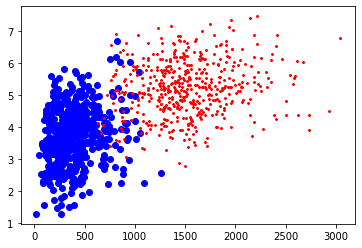


 Gen no: 1
beta: 1043673.8161203166


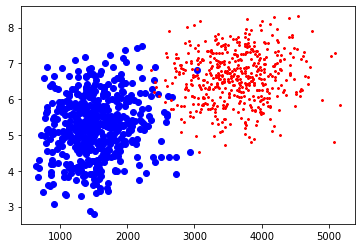


 Gen no: 2
beta: 635426.9034927572


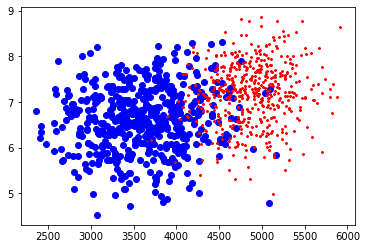


 Gen no: 3
beta: 181305.87864240026


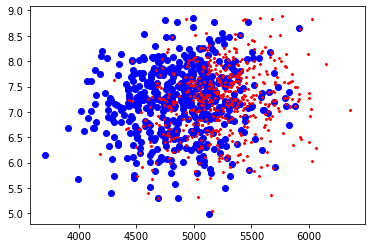


 Gen no: 4
beta: 32473.083001967574


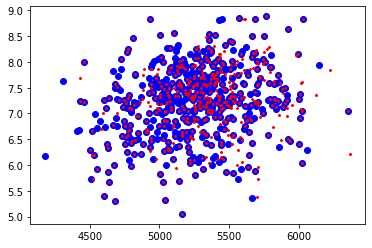


 Gen no: 5
beta: 3133.4705028869585


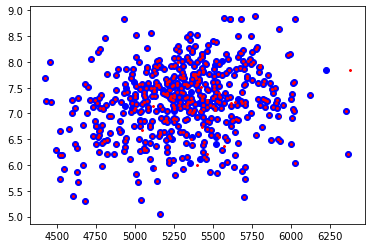


 Gen no: 6
beta: 75.1080073340936


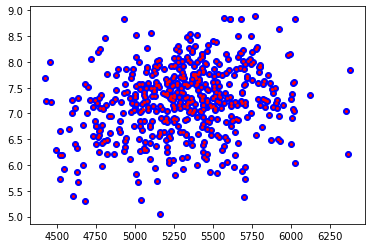


 Gen no: 7
beta: 0.0


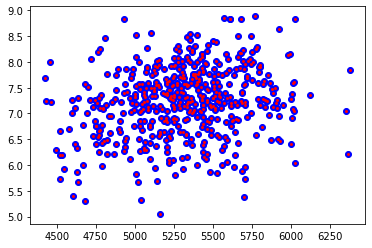

Max Profit: 6377.944
Max Customer Satisfaction: 8.886534467309477
Time taken: 14.278314370833332 mins


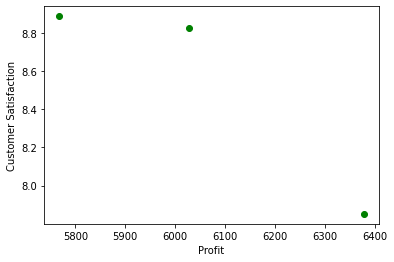

In [17]:
if __name__=='__main__':
    main()